<font size=5  color=#003366> [LELEC2885] - Image Processing <br><br> 
TP3: Sparsity, matching pursuit algorithms, compression aspects </font> <br><br><br>

<font size=5  color=#003366>
Prof. L. Jacques <br>
Prof. C. De Vleeschouwer 
<br><br>
Benoit Brummer (benoit.brummer@uclouvain.be) <br>
Anne-Sophie Collin (anne-sophie.collin@uclouvain.be)<br> 
Olivier Leblanc (o.leblanc@uclouvain.be) <br>
Gabriel Van Zandycke (gabriel.vanzandycke@uclouvain.be) <br>
<div style="text-align: right"> 2021-2022 </div>
<br><br>
</font>

In [1]:
# Installation of dependencies
!python -m pip install numpy matplotlib PyWavelets scipy

In [2]:
# General imports for this practical session
import numpy as np
from matplotlib import pyplot as plt
import pywt
import scipy.fftpack # For DCT 

# Import some custom functions to access all coefficients at once
from TP3_utils import arrayList2vec,vec2arrayList

<font size=6 color=#009999> 0) Warm-up: remember, signals from the real world are sparse! [~20min] </font> <br><br>

Last week, we played with wavelet decompositions of signals. We saw that many natural signals from the real world are ``sparse`` in (well-chosen) wavelet bases. 

This week, we will see among many other things ”how we can use this to build efficient compression schemes (we already did wavelet-based compression last week, but this time it will be one level more realistic). So, in order to start from a good basis (pun intended), let's just quickly recapitulate how to compute the wavelet decomposition of a signal, and observe its sparsity.

First, we will load a ``1D electrocardiogram (ECG) signal`` from pywavelets' database of example signals. This will be our test signal for this session.

*Note: In this practical session, we will mostly be working with 1D signals for simplicity, but the algorithms are easy to translate to the 2D case (e.g., images), by simply vectorizing ("stacking") the 2D signals in one column. Keep this in the back of your head.*

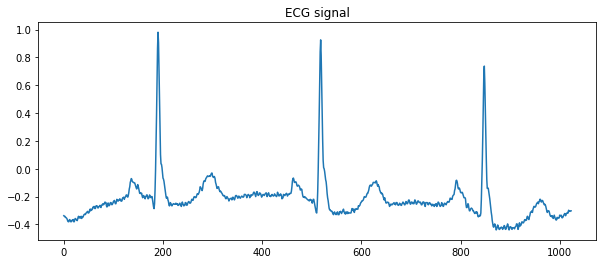

In [3]:
# Load the test ECG signal
x = pywt.data.ecg()/255

# Plot it
plt.figure(figsize=(10,4))
plt.plot(x)
plt.title('ECG signal')
plt.show()

The code that follows performs a 1D wavelet transform over a signal and shows the approximation at the coarsest level, then the details at finer and finer resolution levels. Don't turn your brain off yet however, here is a little warm-up question for you. 

**Question:** What is the effect of the `level` argument of the wavelet decomposition again? Try out some values; which one will be the "best" do you think, and why? *([Hint](https://pywavelets.readthedocs.io/en/latest/ref/index.html))*

Displaying the wavelet coefficients: the approximation at the lowest resolution level (resolution level 0), and the details at all resolution levels up to the highest, 4.


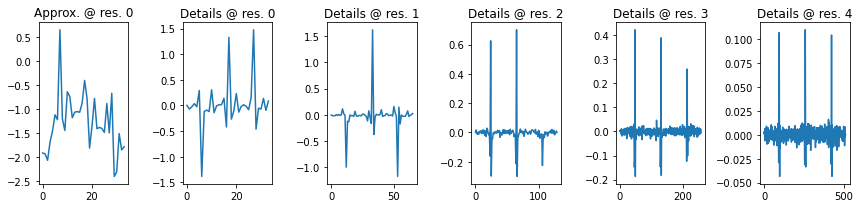

In [4]:
# Finds the signals coefficients in some wavelet basis.
# To do by you: change the wavelet parameters and see what happens!

# Wavelet parameters
wavelet_name = 'db2'  # Don't hesitate to play with the wavelet type too
wavelet_level = 5      # Try to change the level here! 

# Wavelet decomposition
wavelet_coefs_x = pywt.wavedec(x, wavelet_name, level=wavelet_level)

# Plot the wavelet decomposition
plt.figure(figsize=(12,3))
nrows = 1 if wavelet_level < 6 else 2
ncols = int(np.ceil((wavelet_level+1)/nrows))

print('Displaying the wavelet coefficients: the approximation at the lowest resolution level (resolution level 0), and the details at all resolution levels up to the highest, {}.'.format(wavelet_level-1))
for i,w in enumerate(wavelet_coefs_x):    
    plt.subplot(nrows,ncols,i+1)
    plt.plot(w)
    if i == 0:
        plt.title('Approx. @ res. 0') 
    else:
        plt.title('Details @ res. '+ str(i-1)) 
plt.tight_layout()
plt.show()

We say that a signal is *sparse* (resp. *compressible*)â€”in some basisâ€”if it is *exactly* (resp. *approximately*) described by a very small number of nonzero coefficientsâ€”in that particular basis. Let's check this for our ECG signal! Below we give the code to keep only the $K$ strongest (in absolute value) coefficients of the wavelet transform (out of $N_{coef}$ coefficients), then reconstructing the signal back from those coefficients (i.e., we threshold the coefficients such that we keep only a fraction $K$/$N_{coef}$, just as you did last week; the implementation is a bit different though).

**Question:** Play around with $K$, the number of nonzero coefficients kept. How many coefficients do you need to have a "good enough" approximation?

In [5]:
###TO COMPLETE
# Answer the question above
# We can use only 4-5 zon-zero coef. if we are juste interested by the peaks but if we want a perfect
# approximation, we will need thew hundreds coefs. 

###### Note that this time, we won't be playing as much with perturbating particular detail levels. For this reason, we will simply use `arrayList2vec` to convert the wavelets coefficients format returned by `pywavelets` into a 1-dimensional array. Here is a visual recap' of what is going on. Note that `vec2arrayList`, its inverse, requires a "template" list of coefficients; it will reshape the values of the numpy array into the same shape as the given template. <br>

<center> <img src="images/wavelet_explanation.png" alt="wavelet explanation"  width="550" height="450"/> </center>

4 coefficients is enough to have the peak, few hundreds if we want a near perfect reconstruction.

Keeping 0.39% of the coefficients (4 out of 1029)


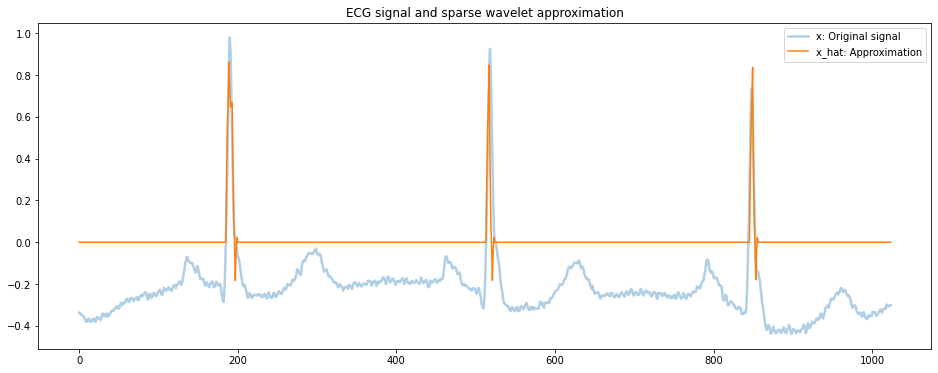

In [6]:
# What you should do:
# Change K, the number of wavelet coefficients kept before inverting, observe how the reconstructed signal changes.
# You should also play with the wavelet type and level

# Redefining the wavelet parameters here for convenience
wavelet_name = 'db2'  

wavelet_level = 2     

# And recomputing the coefficients
wavelet_coefs_x = pywt.wavedec(x, wavelet_name, level=wavelet_level)

# Flatten the coefficients
wavelet_coefs_x_flat = arrayList2vec(wavelet_coefs_x)
nb_coefs = wavelet_coefs_x_flat.size
    
# Erase some coefficients
K = 4 # <-- Play with this value, initial = 200
indinces_toKeep = np.argpartition(np.abs(wavelet_coefs_x_flat), -K)[-K:] # Find the indices of the K strongest coefficients
print('Keeping {:.2f}% of the coefficients ({} out of {})'.format((100*K/nb_coefs),K,nb_coefs))

mask = np.ones(nb_coefs, bool)
mask[indinces_toKeep] = False    # Protect the strongest coefficients...
wavelet_coefs_x_flat[mask] = 0.  # ... and erase the rest!

# Reconstruction
wavelet_coefs_xapprox = vec2arrayList(wavelet_coefs_x_flat,original_coefs_template = wavelet_coefs_x)
x_hat = pywt.waverec(wavelet_coefs_xapprox,wavelet_name)

# Finally, plot the approximation
plt.figure(figsize=(16,6))
plt.title('ECG signal and sparse wavelet approximation')
plt.plot(x,alpha=0.35,lw=2.5)
plt.plot(x_hat)
plt.legend(['x: Original signal','x_hat: Approximation'])
plt.show()

This question of finding a "good enough" approximation is however a little bit vague (one might say, "unscientific"). 
We would like to qualify the reconstruction, so let's find a rigorous way to measure the error commited.
Besides the ``MSE`` and ``PSNR`` that we saw last week, one of the most popular ways to do this is to compute the ``Signal-to-Noise ratio (SNR)``. For a true signal $I$ and its approximation $\hat{I}$, the SNR in decibels is given by:


$$
\mathit{SNR} = 10\cdot \log_{10}\left(\frac{\sum_{i,j}I^2_{i,j}}{\sum_{i,j}e^2_{i,j}}\right),
$$

where $e = I - \hat{I}$ is the approximation error. Notice we took $I$ as a 2D signal, e.g. an image, because of the two subscripts $i,j$, but this definition remains valid for 1D signals.

**Question:** Implement a function computing the SNR of a given signal. Use it to evaluate the quality of different wavelet approximations to the signal above (for example, try the following wavelets: `haar`, `db2`, `db4`, `db12`,...). Try to explain: what is the difference with the **P**SNR that you implemented last week? Try to think of reasons why you may prefer one or the other.

In [7]:
def computeSNR(I,I_hat):
    """Returns the signal-to-noise ratio (in decibels) for a clean signal I and its approximation I_hat."""
    SNRdB = 0.
    ### TO COMPLETE
    e = I - I_hat
    SNRdB = 10 * np.log10(np.sum(I**2) / np.sum(e**2))
    
    return SNRdB

print('The SNR is: {:.2f} dB.'.format(computeSNR(x,x_hat)))

The SNR is: 0.43 dB.


In [ ]:
###TO COMPLETE
# Answer the question above
# SNR will be based on every pixels while PSNR is based on max intensity. PSNR would be better for image I think.

Okay, warm-up is over, let's dive into the world of the sparse approximation problem! <br>
<font size=6 color=#009999> 1) Matching Pursuit  [~40min] </font> <br>

So, real-world signals are sparse, but as you should have noticed by playing with the wavelet types above, they may be better approximated in one given basis than in another.

**Question:** In fact, given *any* signal, we could theoretically always find some basis where this signal is _very_ sparse! Can you explain why? Why is it not especially useful?
- At some point we can loose some information, some details

One way to account for this problem is to fuse different bases, each approximating well some part of the signal, together. This results in what is called an ``overcomplete dictionnary``. This is but one of theâ€”multipleâ€”applications that come from solving the ``sparse approximation problem``. As implied in the name "problem", in this case finding the coefficients becomes tricky. Solving the sparse approximation problem will be the main theme of this practical session.

For this section we first consider, as a pedagogical example, the following 'toy example' signal: a simple combination of an impulse and a cosine[1] (this is the "Ground Truth" signal $x_{GT}$) that is then corrupted by additive Gaussian noise, giving $x$. Our goal will be to express this signal by only a only few coefficients: since the noise is *not* sparse in our considered basis, we will this way obtain a denoised version of out signal! Neat!

[1] *Remark: we use the [Discrete Cosine Transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform) basis. For our purposes here, just remember that it is like a Fourier basis, but specific to real-valued discrete signals.*

In [33]:
###TO COMPLETE
# Answer the question above
# At some point we can loose some information, some details

Displaying the elements constituting the toy example signal (except for the noise)


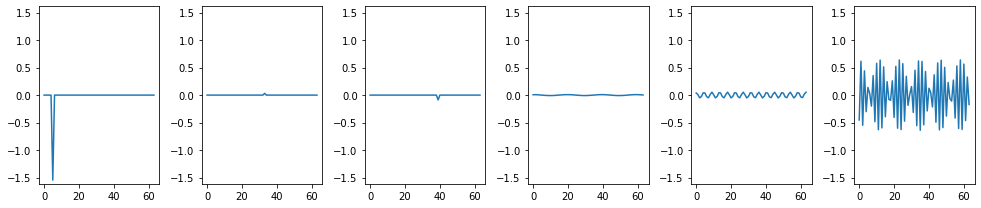

Displaying x_GT the generated and x the actually recorded (noisy) signal in the direct and DCT domain


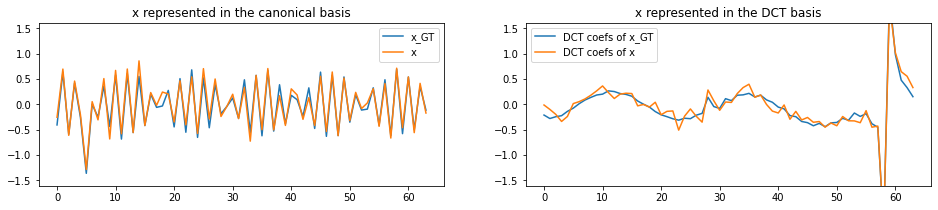

In [10]:
# Import function to generate toy example signals
from TP3_utils import genSparseInDictionnaries
    
# Parameters of the generated signal
N = 64 # dimension
K_per_dico = 3 # number of nonzero coefficients per dictionnary -> fixes the GT sparsity
noise_std = 0.1
# The dictionnaries
canonicalBasis = np.eye(N)
fourierBasis = scipy.fftpack.idct(canonicalBasis,norm='ortho')
dico_list = [canonicalBasis,fourierBasis]

# Generate the signal
# In what follows, x is the observed---noisy!---signal and a_GT are its coefficients (before noise corruption)
# (note: in a realistic setting, we would observe x but not a_GT of course!)
(x,a_GT_list) = genSparseInDictionnaries(K_per_dico,dico_list,noise_std)
K_GT = K_per_dico*len(dico_list) # GT sparsity

a_GT = np.concatenate(a_GT_list) # Put all the coefficients into one unique vector
D = np.concatenate(dico_list,axis=1) # Concatenate all dictionnaries into one fat matrix
x_GT = D@a_GT

print('Displaying the elements constituting the toy example signal (except for the noise)')
plt.figure(figsize=(16,3))
# Plot params
nrows = 1 if K_GT < 7 else 2
ncols = int(np.ceil((K_GT+1)/nrows))
lim = 1.25*np.abs(x).max()
for i,a_index in enumerate(np.where(a_GT)[0]): # enumerate the nonzero coefficients indices
    plt.subplot(nrows,ncols,i+1)
    plt.plot(a_GT[a_index]*D[:,a_index])
    plt.ylim((-lim,lim))
plt.tight_layout()
plt.show()

print('Displaying x_GT the generated and x the actually recorded (noisy) signal in the direct and DCT domain')
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.plot(x_GT)
plt.plot(x)
plt.legend(['x_GT','x'])
plt.ylim((-lim,lim))
plt.title('x represented in the canonical basis')

plt.subplot(1,2,2)
plt.plot(scipy.fftpack.dct(x_GT,norm='ortho'))
plt.plot(scipy.fftpack.dct(x,norm='ortho'))
plt.title('x represented in the DCT basis')
plt.legend(['DCT coefs of x_GT','DCT coefs of x'])
plt.ylim((-lim,lim))
plt.show()

As you can see, this signal (even without noise) is neither sparse in the direct domain (left) nor the frequency domain (right). However, it is very sparse when represented in both domains ``together``! To find the coefficient $a \in \mathbb R^d$ in the *dictionnary* $D \in \mathbb R^{N \times d}$ obtained by bringing together both bases, we start from the following formulation of the sparse approximation problem, where the sparsity $K$ is imposed *a priori*:

$$\hat{a} = \arg \min_a \frac{1}{2} \|x - D a\|^2_2 \quad \text{s.t.} \quad \|a\|_0 \leq K.$$

And build a greedy algorithm reminded here :

<center> <img src="images/MP.PNG" alt="MP algorithm" width="450" height="180"/> </center>

Together, we will solve this optimization problem by coding a ``Matching Pursuit (MP)`` algorithm. Globally, it adds up $K$ coefficients to $a$ while greedily minimizing the norm of the ``residual`` $r := x - D a$.

Visualizing the dictionary D:


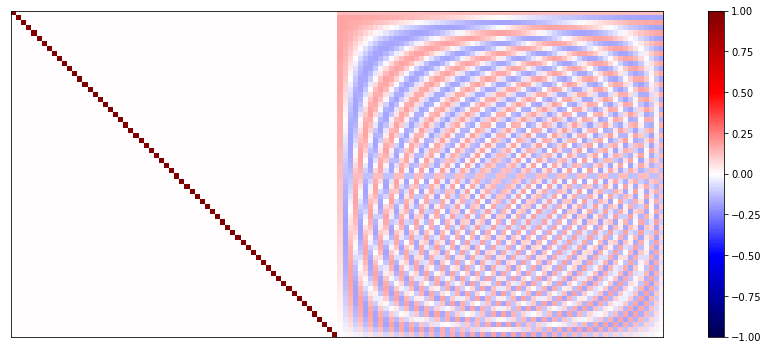

The Ground-Truth (i.e., unknown in practice!) coefficients of x in D:


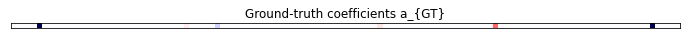

In [11]:
# Creating the dictionary
D = np.concatenate((canonicalBasis,fourierBasis),axis=1) # You could put other bases here!
(_,d) = D.shape # d denotes the total dictionnary size

# Visualize the dictionary using a custom function
from TP3_utils import visualizeDictionary
print('Visualizing the dictionary D:')
visualizeDictionary(D)

print('The Ground-Truth (i.e., unknown in practice!) coefficients of x in D:')

visualizeDictionary(np.expand_dims(a_GT,axis=0),figsize=(12,10),colorbar=False,title='Ground-truth coefficients a_{GT}')


# Initialization of the Matching Pursuit algorithm
a_hat = np.zeros(d)
r = x # Residual

<font size=5 color=#009999> MP step 1: Finding the most correlated atom </font> <br>

At each iteration $k$, the first step of the MP algorithm is to add one index $i$ to the support of $a$ (the support of $a$ at iteration $k$ is denoted $\Omega_k$):
$
    \Omega_k \leftarrow \Omega_{k-1} \cup \{i\}.
$

To select this index $i$, we greedily choose the atom (column of the dictionnary) that is the ``most correlated`` with the residual $r$.

**Question:** Why maximizing the correlation with the residual? Implement this step; the function below should return the selected index.

In [12]:
###TO COMPLETE
# Answer the question above


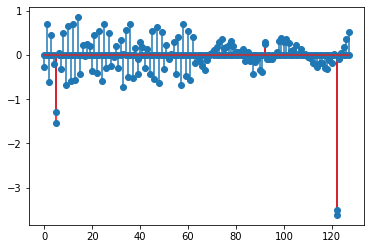

In [13]:
def MP_select_bestAtom(D,r, debug=False):
    """Select the atom in D that is the most correlated with r."""
    
    selected_atom_index = 0
    # TO COMPLETE. Plotting the correlation result is a good way to check your result
    correlations = D.T @ r
    
    if debug:
        plt.stem(correlations)
        plt.stem(a_GT,linefmt='red')
        plt.show()
    
    selected_atom_index = np.argmax(np.abs(correlations))
    
    return selected_atom_index

i = MP_select_bestAtom(D,r, debug=True)
selected_atom = D[:,i]

<font size=5 color=#009999> MP step 2: Finding the coefficient update for the selected atom </font> <br>

Having selected the index $i$ that we will add to the support of $a$, we have to select the value of this coefficient. This is done by ``projecting`` the residual onto the selected atom $d_i$.

**Question:** Express this coefficient update $\Delta a \in \mathbb R^d$ below. Do you require an assumption on $D$? Why?

In [34]:
###TO COMPLETE
# Answer the question above
# Voir basis pursuit/matching dans le cours

In [15]:
def MP_coefficientUpdate(D,r,i):
    """Compute the coefficient update for atom i (to be added to the coefficient vector a)."""
    # This vectors updates all the coefficients at once, please be careful!
    (_,d) = D.shape 
    coef_update = np.zeros(d) # Remember (_,d) = D.shape 
    # TO COMPLETE. Ensure the atom is normed.
    selected_atom = D[:,i]
    e_i = np.zeros(d)
    e_i[i] = 1.
    coef_update = (selected_atom @ r * e_i) / (selected_atom @ selected_atom)
    
    return coef_update

a_hat += MP_coefficientUpdate(D,r,i)

<font size=5 color=#009999> MP step 3: Updating the residual </font> <br>

Finally, the last step is rather easy: we have to update the residual to take into account the newly added atom.

**Question:** Express the update of the residual. Do you rememeber why its ($\ell_2$) norm will always decrease?

In [35]:
###TO COMPLETE
# Answer the question above
# Voir basis/matching pursuit dans le cours

In [17]:
def MP_updateResidual(x,D,a_hat):
    r = np.zeros(N)
    # TO COMPLETE
    r = x - D @ a_hat
    
    return r

r = MP_updateResidual(x,D,a_hat)

<font size=5 color=#009999> Putting all together: our first matching pursuit algorithm! </font> <br>

Finally, the Matching Pursuit algorithm repeats this process $K$ times, to obtain a support of $K$ elements. This is done by the function below. It is implemented but be sure you understand it.

In [18]:
def MatchingPursuit(x,D,K,showIters=False):
    """Implements the Matching Pursuit algorithm to approximately solve
        a_hat = min_a (1/2) ||x - D a||^2_2     s.t.     ||a||_0 <= K.
    """
    
    # Initialization
    (N,d) = D.shape
    a_hat = np.zeros(d)
    r = x
    support_mask = np.zeros(d, bool) # Represents the selected support Omega

    
    # Matching Pursuit algorithm, it calls the functions you implemented above!
    for k in range(K):
        # Step 1
        i = MP_select_bestAtom(D,r)
        # Step 2
        a_hat += MP_coefficientUpdate(D,r,i) 
        # Step 3
        r = MP_updateResidual(x,D,a_hat)
        
        # Visualize, comment below to get rid of it
        if showIters and ((k < 5) or (k > K-3)):
            visualizeDictionary(np.expand_dims(a_hat,axis=0),figsize=(12,10),colorbar=False,title='a_hat_MP at iteration {}'.format(k+1))


    return a_hat

Time to test it! The cell below calls your Matching Pursuit method on our example data.

**Question:** Run your MP algorithm with the code below. Try to interpret: what happens when we over- or under-estimate the sparsity level $K$ (recall that in a real-life setting, we typically do not know $K$ in advance)? What happens when we increase/decrease the noise level? Why?

When interpreting the results below (especially the two graphs at the bottom), remember that in practice, when you observe a signal, you do not actually know $a_{GT}$ (here we know those coefficients because we crafted this signal articifially ourselves)! We compute two SNR values, which one is actually sensible?

In [19]:
###TO COMPLETE
# Answer the question above


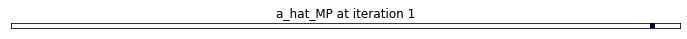

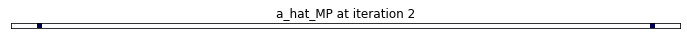

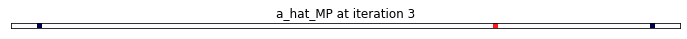

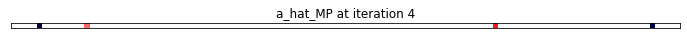

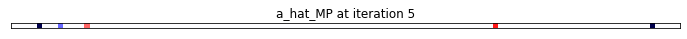

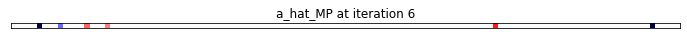

The support size of the MP solution is 6 (target sparsity: 6).


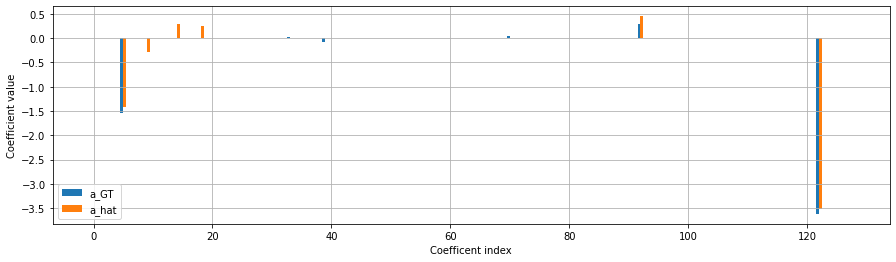

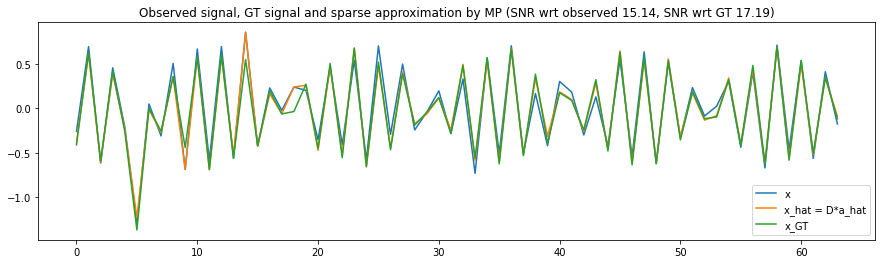

In [20]:
# Run the matching pursuit algorithm
K = 6
a_hat = MatchingPursuit(x,D,K,showIters=True)

print('The support size of the MP solution is {} (target sparsity: {}).'.format(np.where(a_hat != 0)[0].size,K))

# Visualize the resulting coefficients and compare to ground truth coefs
indices = np.arange(len(a_hat))
width = 0.5
plt.figure(figsize=(15,4))
plt.bar(indices - width/2, a_GT, width,label='a_GT')
plt.bar(indices + width/2, a_hat, width,label='a_hat')
plt.xlabel('Coefficent index')
plt.ylabel('Coefficient value')
plt.legend()
plt.grid(True)
plt.show()

x_hat = D@a_hat
x_GT = D@a_GT
plt.figure(figsize=(15,4))
plt.plot(x)
plt.plot(x_hat)
plt.plot(x_GT)
plt.title('Observed signal, GT signal and sparse approximation by MP (SNR wrt observed {:.2f}, SNR wrt GT {:.2f})'.format(computeSNR(x,x_hat),computeSNR(x_GT,x_hat)))
plt.legend(['x','x_hat = D*a_hat', 'x_GT'])

# plt.subplot(1,2,1)
# plt.plot(x)
# plt.plot(x_hat)
# plt.title('Observed signal and sparse approximation by MP (SNR {:.2f})'.format(computeSNR(x,x_hat)))
# plt.legend(['x','x_hat = D*a_hat'])

# x_GT = D@a_GT
# plt.subplot(1,2,2)
# plt.plot(x_GT)
# plt.plot(x_hat)
# plt.title('GT signal and sparse signal approximated by MP (SNR {:.2f})'.format(computeSNR(x_GT,x_hat)))
# plt.legend(['x_GT','x_hat = D*a_hat'])

plt.show()

<font size=5 color=#009999> Going further: *Orthogonal* Matching Pursuit </font> <br>

Hopefully, Matching Pursuit yielded decent results. However, it's a very basic algorithm: in particular, it is *very* greedy, since at each iteration, no consideration is given at all at the possible future choices, but also at the previous choices! In particular, one issue with Matching Pursuit is that one same atom can be selected multiple times (you have maybe oberved this issue by running the cell just above during your tests, especially for large values of $K$). 

It is possible to improve this slightly by taking the previously selected atoms into account when updating their related coefficients (in step 2). This is exaclty what ``Orthogonal Matching Pursuit (OMP)`` does. At each iteration $k$, the coefficients of the selected atoms are obtained by solving

$$\hat{a} = \arg \min_a \frac{1}{2} \|x - D a\|^2_2 \quad \text{s.t.} \quad \mathrm{supp}(a) \subset \Omega_k.$$

Where the algorithm of OMP is :

<center> <img src="images/OMP.PNG" alt="OMP algorithm" width="600"/> </center>

**Question:** Wait a minute, isn't this almost the same problem as the one of the MP algorithm ? Are you able to identify what changed here? Why is this one easier? Implement the Orthogonal Matching Pursuit algorithm below.

In [21]:
###TO COMPLETE
# Answer the question above


In [22]:
def OMP_coefficientUpdate(D,x,support_mask):
    """Compute the best coefficients with support in support_mask."""
    (_,d) = D.shape
    a_hat = np.zeros(d)
    # TO COMPLETE
    a = 2 * np.linalg.lstsq(D,x)[0]    # Least squarre approximation
    a_hat[support_mask] = a[support_mask]
    
    return a_hat


def OrthogonalMatchingPursuit(x,D,K,showIters=False):
    """Implements the Orthogonal Matching Pursuit algorithm to approximately solve
        a_hat = min_a (1/2) ||x - D a||^2_2     s.t.     ||a||_0 <= K.
    """
    
    # Initialization
    (N,d) = D.shape
    a_hat = np.zeros(d)
    r = x
    support_mask = np.zeros(d, bool) # Represents the support set Omega
    
    # Matching Pursuit algorithm, it calls the functions you implemented above!
    for k in range(K):
        # Step 1
        i = MP_select_bestAtom(D,r)
        support_mask[i] = True # Add it to the support

        # Step 2
        a_hat = OMP_coefficientUpdate(D,x,support_mask) 
        
        # Step 3
        r = MP_updateResidual(x,D,a_hat)
        
        # Visualize, comment below to get rid of it
        if showIters and ((k < 5) or (k > K-3)):
            visualizeDictionary(np.expand_dims(a_hat,axis=0),figsize=(12,10),colorbar=False,title='a_hat_OMP at iteration {}'.format(k+1))


    return a_hat

Let's try out OMP this time.

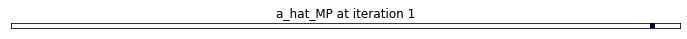

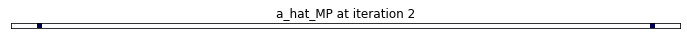

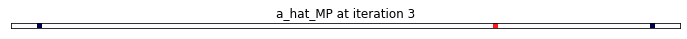

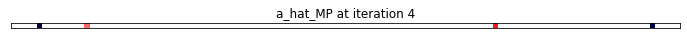

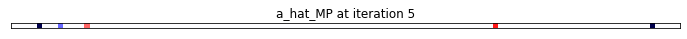

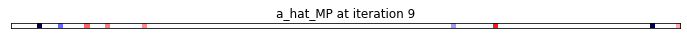

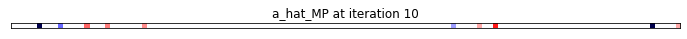

The support size of the MP solution is 10 (target sparsity: 10).


<ipython-input-22-176f1e13b056>:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = 2 * np.linalg.lstsq(D,x)[0]


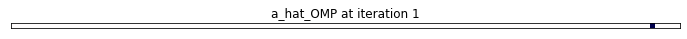

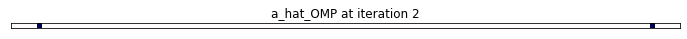

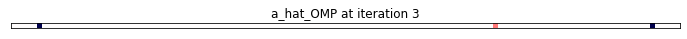

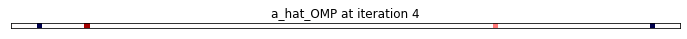

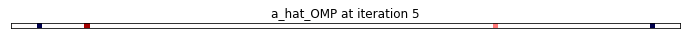

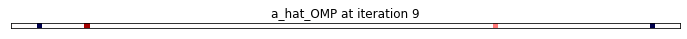

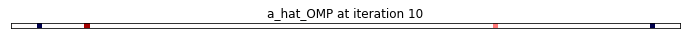

The support size of the OMP solution is 4 (target sparsity: 10).


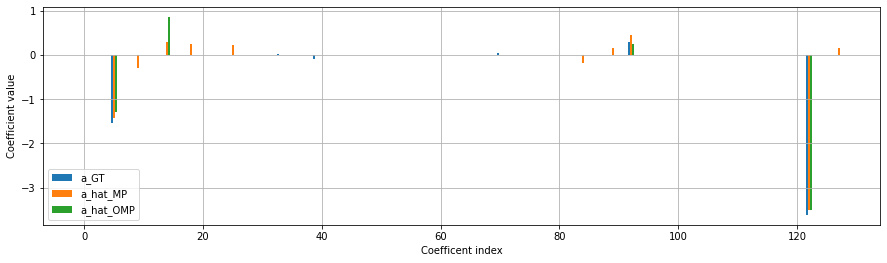

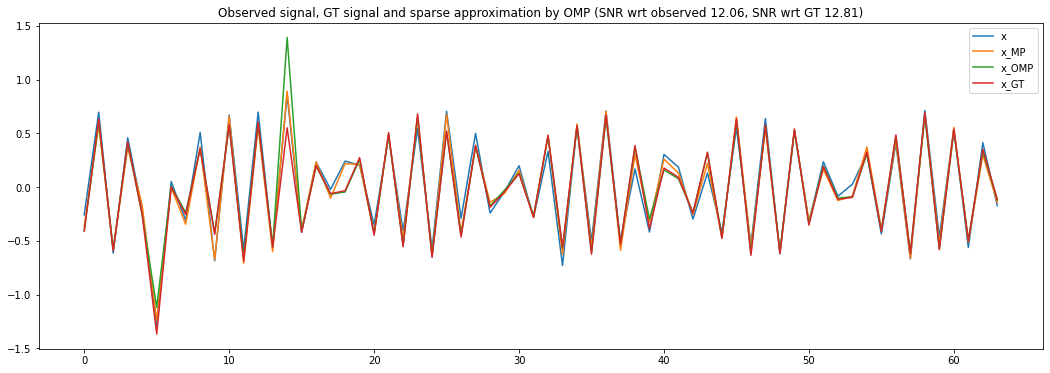

In [23]:
# Run the orthogonal matching pursuit algorithm and compares it to the simple MP
K = 10
a_hat_MP = MatchingPursuit(x,D,K,showIters=True)
print('The support size of the MP solution is {} (target sparsity: {}).'.format(np.where(a_hat_MP != 0)[0].size,K))

a_hat_OMP = OrthogonalMatchingPursuit(x,D,K,showIters=True)
print('The support size of the OMP solution is {} (target sparsity: {}).'.format(np.where(a_hat_OMP != 0)[0].size,K))


# Visualize the resulting coefficients and compare to ground truth coefs
indices = np.arange(len(a_hat))
width = 0.35
plt.figure(figsize=(15,4))
plt.bar(indices - width, a_GT, width,label='a_GT')
plt.bar(indices, a_hat_MP, width,label='a_hat_MP')
plt.bar(indices + width, a_hat_OMP, width,label='a_hat_OMP')
plt.xlabel('Coefficent index')
plt.ylabel('Coefficient value')
plt.legend()
plt.grid(True)
plt.show()

# MP results
x_hat_MP = D@a_hat_MP
x_GT = D@a_GT

# OMP results
x_hat_OMP = D@a_hat_OMP

plt.figure(figsize=(18,6))
plt.plot(x)
plt.plot(x_hat_MP)
plt.plot(x_hat_OMP)
plt.plot(x_GT)
plt.title('Observed signal, GT signal and sparse approximation by OMP (SNR wrt observed {:.2f}, SNR wrt GT {:.2f})'.format(computeSNR(x,x_hat_OMP), computeSNR(x_GT,x_hat_OMP)))
plt.legend(['x','x_MP', 'x_OMP', 'x_GT'])
plt.show()

Now, we have an algorithm to solve the sparse approximation problem! There are many others (Iterative Hard/Soft Thresholding, Convex optimization-based approaches such as Basis Pursuit,...), but instead of going over all of them, let's see some applications of what we can do with them.

<font size=6 color=#009999> 2) A simple dictionnary-based lossy compression  [~40min] </font> <br>

In this section we use the dictionnary coefficients as a *very* simple (i.e., this is not how image compression is done in practice, you will learn more about how image compression *actually* works at the end of this course) way of compressing a given signal. 

Let's get back to our example signal. To simplify things, let's assume it's values lie within -1 and +1 : $x_i \in [-1,+1]$.

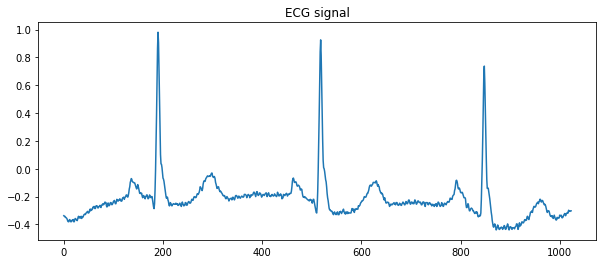

In [24]:
# Load the test ECG signal
x = pywt.data.ecg()/255 # Arbitrarily divide by 255 to have |entries| <= 1

# Parameters
N = x.size # dimension

# Plot it
plt.figure(figsize=(10,4))
plt.plot(x)
plt.title('ECG signal')
plt.show()

In this simplistic example, suppose we numerically encode the coefficients $a$ as follows (this is not what we will actually do in the python implementation, but we could do it in a low-level implementation). If the $i$-th coefficient :
- $a_i = 0$ : encode a $\texttt{0}$ on a single ``flag`` bit.
- $a_i \neq 0$ : set the flag bit to $\texttt{1}$ and then build an associated decimal value which is the full coefficient quantized using $b$ bits. For this last quantization, we assume a least-squares quantization under the hypothesis that the coefficients are uniformly distributed in $[-1,+1]$ (a somewhat naive assumption considering our observations last week).

**Question:** using this scheme, how many bits are required to encode the $K$-sparse coefficients of an $N$-dimensional signal with a dictionnary containing $d$ elements? We suppose that the dictionnary is known by the decoder. Is this compression ``lossy`` or ``lossless`` (i.e., does the compression induce errors)? Implement this quantization scheme below.

In [25]:
###TO COMPLETE
# Answer the question above
# Sur b bits veut dire 2^b valeurs possibles 

In [26]:
def custom_quantize_oneCoefficient(a_i,b):
    """
    Quantizes one scalar coefficient a_i on b bits using a simple "least-squares quantization"*. Saturates at +- 1.
    
    Output : 
     - a_i_q : a_i, quantized using b bits, still in decimal format.
    
    *This means that the quantization values Q = {q_i}_{i = 1}^{2**b} are such that 
        {Q} = arg min_{Q} E_{x ~ U([-1,+1])} min_{q_i in Q} (x - q_i)^2.
     What is the solution Q of this problem? :-)
    """
    a_i_q = 0  # TO COMPLETE
    
    # Sur b bits veut dire 2^b valeurs possibles 
    extr_val = np.linspace(-1, 1, 2**b + 1) 
    # +1 car allow_values ne va garder que les valeurs centrales donc va avoir une taille en -
    # Ici on génère un vecteur allant de -1 à 1 avec 2^b valeurs possibles
    
    allow_val = (extr_val[0:-1] + extr_val[1:]) / 2 
    # Best quantization vectors are in the middle
    # [0:-1] prend tous les éléments de l'index 0 en excluant le dernier (-1)
    # [1:]prend tous les éléments sauf le dernier
    # la ligne calcule donc tous les éléments "centraux" du vecteur extr_values
    
    a_i_q = allow_val[np.argmin(np.abs(a_i - allow_val))] 
    # argmin renvoie l'indice de la plus petite valeur
       
    return a_i_q

def custom_quantize_coefficientVector(a,b):
    """
    Quantizes the whole coefficient vector a using 1 bit per coefficient for flagging nonzero values,
    then b bits to quantize the nonzero values in a. 
    
    Returns:
        - a_q: the coefficients vector a, but where nonzero values are quantized by 'custom_quantize_oneCoefficient'
        - support_mask: a boolean array, the flag bits of a. support_mask[i] is True whenever a[i] is nonzero
        - a_q_onSupport: numpy array, the quantized nonzero decimal values of a_q at their nonzero indices
    
    Note that a_q is thus not the actual encoded bitstream!
    The encoded bitstream is "support_mask" followed by the b-bit encoding of those nonzero values, "a_q_onSupport".
    """
    
    # Compute the support
    support_mask = np.zeros(d, bool)
    indexes_nonzero = np.where(a != 0)
    support_mask[indexes_nonzero] = True
    
    # Quantize a_q on the support 
    a_q = np.zeros(a.size)
    for i in indexes_nonzero[0]: # Naive for-loop implementation
        a_q[i] = custom_quantize_oneCoefficient(a[i],b)
    a_q_onSupport = a_q[indexes_nonzero]
    
    return a_q, support_mask, a_q_onSupport

How to best compare the different compression schemes (e.g. the dictionary based and the quantization based)? The standard way to do this is to draw ``rate-distorsion curves``! In our simplistic example, we assume that the ``rate`` is simply the number of bits required for our encoding defined above, and the ``distorsion`` is the ``Mean-Squared Error (MSE)`` between the signal to compress and its compressed version. To draw a rate-distorsion curve, we pick different values of $K$ and compute the rate and distorsion.

**Question:** Complete both functions below.

In [27]:
def MSE(x,x_hat):
    """Compute the Mean Square Error between x and x_hat"""
    MSE = 0 # TO COMPLETE, you should already know how to do this ;-)
    MSE = np.square(np.subtract(x, x_hat)).mean() 
    
    return MSE

def rate_distorsion(x,D,Ks,b):
    """Compute a Rate-Distorsion curve for our simple lossy compression scheme.
    
    Arguments:
        - x: numpy array, the signal to compress
        - D: numpy array, the dictionary used by the encoder
        - Ks: numpy array of ints, the different values of K to consider to draw the curve
        - b: int, the number of bits to use per encoded coefficient
    Outputs:
        - rate: numpy array of ints, the number of bits required for encoding for each K value
        - distorsion: numpy array, MSE between the signal to compress and its compressed version for each K value
    """
    
    nb_Ks = Ks.size
    rate = np.zeros(nb_Ks) # TO COMPLETE
    distorsion = np.zeros(nb_Ks) # TO COMPLETE
    
    (_,d) = D.shape
    
    for K_index in range(Ks.size):
        # Selection of a 'K'
        K = Ks[K_index]
        
        # Compute the 'rate'
        rate[K_index] = d + K*b   # d bits to encode 0 or not, b bits per non-zero coefficient
        
        # Compute the 'distorsion'
        a_hat_OMP = OrthogonalMatchingPursuit(x,D,K) 
        # Find the K nonzero coefficients
        
        # And encode them
        (a_hat_q,_,_) = custom_quantize_coefficientVector(a_hat_OMP,b)
        
        # The represented signal is
        x_hat = D @ a_hat_q
        
        if (K % 5 == 1 and False):
            print(np.where(a_hat_q != 0))
            plt.plot(x)
            plt.plot(x_hat)
            plt.show()
            
        distorsion[K_index] = MSE(x,x_hat)
    
        
    return rate,distorsion

Let us test it.

**Question:** Run the code cells below to plot a rate-distorsion curve. How do you interpret it? Try different combinations for the dictionnaries!

In [28]:
###TO COMPLETE
# Answer the question above


In [29]:
# Import function to build the Psi matrix of a wavelet transform
from TP3_utils import makeWaveletBasis

# Create the dictionnary elements (feel free to add others)
canonicalBasis = np.eye(N)
fourierBasis = scipy.fftpack.idct(canonicalBasis,norm='ortho')
waveletBasisHaar = makeWaveletBasis(N,'haar')
waveletBasisDB2 = makeWaveletBasis(N,'db2')

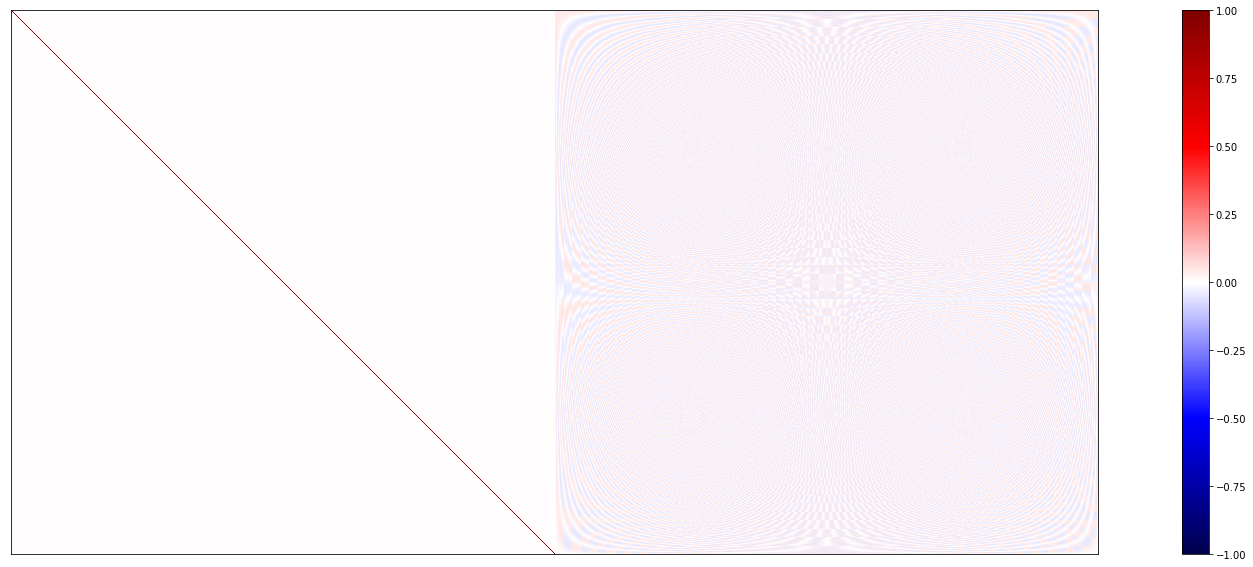

In [30]:
# Chose two dictionnaries
dico_list = [canonicalBasis,fourierBasis]

D = np.concatenate(dico_list,axis=1)
(_,d) = D.shape # d denotes the total dictionnary size
visualizeDictionary(D,(30,10))

<font size=3 color=#FF0000> Warning</font> <br>

The following cell might be a little bit heavy to be fast on your machine (~1m30s on our machine). Consider subsampling the Ks if needed.

In [31]:
# The values of K to test
Ks = np.arange(1,N/8).astype(int) 
b = 4
#(rate,distorsion) = rate_distorsion(x,D,Ks,b)

Instead of the rate directly, we plot the ``compression ratio``, that is, the rate divided by the number of bits that were required to encode the original signal (we assume each sample is represented by $64$ bits).

In [32]:
nbBitsOriginalSignal = 64*N
plt.plot(100*rate/nbBitsOriginalSignal,distorsion)
plt.xlabel('Compression ratio [%]')
plt.ylabel('Distorsion - MSE')
plt.show()

NameError: name 'rate' is not defined

We can now compare different choices for the parameters in our compression scheme.

**Question:** Compare different choices of the bit depth $b$: which one is the best? Compare also different choices for the dictionnary $D$: is a larger dictionnary always better?

In [ ]:
# TO COMPLETE: compare, with as figure of merit the rate-distorsion curves, different sparse coding schemes

**Question:** Time for critical thinking. Imagine that you would design your own new compression scheme. What would you change with respect to the workflow we followed right now? Why?

In [ ]:
###TO COMPLETE
# Answer the question above


<font size=6 color=#009999> 3) Another application: inpainting  [~20min] </font> <br>

To finish, let's into this other cool application of the sparse recovery problem (don't worry, minimal coding effort is involved!).
For this more challenging task (i.e., harder to solve on real data), consider again a very simple synthetic signal $x$.

In [ ]:
N = 64 # dimension

# The dictionnaries
canonicalBasis = np.eye(N)
fourierBasis = scipy.fftpack.idct(canonicalBasis,norm='ortho')
waveletBasisHaar = makeWaveletBasis(N,'haar')
waveletBasisDB2 = makeWaveletBasis(N,'db2')
dico_list = [canonicalBasis,waveletBasisHaar,fourierBasis,waveletBasisDB2] # Arbitrarily chose some dicts

K_per_dico = 2 # number of nonzero coefficients per dictionnary

# In what follows, x is the observed---noisy!---signal and a_GT are its coefficients (before noise corruption)
# (note: in a realistic setting, we would observe x but not a_GT of course!)
(x,a_GT_list) = genSparseInDictionnaries(K_per_dico,dico_list,0)
K = K_per_dico*len(dico_list)


# Plot it
plt.plot(x)
plt.title('Original signal x')
plt.show()

Now, assume that the sensor was malfunctioning when we aquired this signal. In particular, for each time instant, there is a probability $p_f$ (for example here, $40\%$) that the sensor didn't record anything! We obtain the following signal $x_{cor}$:

In [ ]:
p_f = 0.4 # Failure probability, don't hesitate to come back and change this later !

mask = np.random.choice([False,True], size=N, p = [p_f,1-p_f]) # True if we obtained the pixel
x_cor = np.copy(x)
x_cor[~mask] = np.nan # The signal is lost

plt.plot(x_cor, "o-", markersize=1.5)
plt.title('Actually recorded ECG signal with mask corruption, x_cor')
plt.show()

We want to recover the initial signal $x$ without the corruption. To do this, assume that $x$ is sparse in some well-chosen basis or dictionary.

**Question:** Formulate an inpainting optimization problem in the form of the sparse recovery problem. In particular, what (simple) change do you have to perform? Implement the inpainting of the signal above. Try some things out to answer some of the following questions: How high can $p$ get? How to best select $K$, $D$? Does it outperform simple interpolation (see e.g. `scipy.interpolate`)? What when we have a real-life signal such as the ECG one? What are the limits of the approach and what could you do to improve it?

We want to minimize the SNR 

In [ ]:
x_hat = np.zeros(N)

# TO COMPLETE


# For interpolating see e.g. https://stackoverflow.com/questions/49360576/interpolating-missing-data-in-python-keeping-in-mind-x-values
# Remark that our prior is not very adapted to the signal here

plt.figure(figsize=(16,6))
plt.plot(x,alpha=0.2,lw=4.5)
plt.plot(x_cor, "o-",alpha=0.9,lw=4,markersize=4)
plt.plot(x_hat)
plt.legend(['x','x_cor','x_hat'])
plt.show()

## Some references to go further:
* Numerical tours of G. PeyrÃ©, e.g. [entropic coding](https://nbviewer.jupyter.org/github/gpeyre/numerical-tours/blob/master/python/coding_2_entropic.ipynb), or also [Introduction for fourier wavelets](https://nbviewer.jupyter.org/github/gpeyre/numerical-tours/blob/master/python/introduction_4_fourier_wavelets.ipynb)
* [Denoising with wavelets in the scikit-image package](https://scikit-image.org/docs/stable/api/skimage.restoration.html#skimage.restoration.denoise_wavelet)

